In [69]:
# import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split

np.random.seed(23)

%matplotlib inline

## Objectives

* Feature Importance ( Random Forest Classifier and Gradient Boosting Classifier )
* Feature Engineering for Tree Based Models

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,0.366667,0.611765,0.05,0,0.110435,0.803973,0.106075,0.473965,0.835617,0.106452,...,1,1,1,1,0,1,0,0,1,0
1,0.100000,0.758175,0.30,0,0.180128,0.621378,0.287144,0.503919,0.674919,0.403616,...,0,0,0,0,0,0,0,0,0,0
2,0.100000,0.658812,0.10,0,0.243421,0.640959,0.312765,0.279784,0.686775,0.280301,...,0,0,0,0,0,0,0,0,0,0
3,0.100000,0.655752,0.10,0,0.226978,0.776996,0.150657,0.336948,0.802121,0.125608,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.484851,0.00,0,0.561200,0.771463,0.244287,0.293096,0.717575,0.230842,...,0,0,0,0,0,0,0,0,0,0


## Look for categorical features

In [10]:
def get_num_unique_values(df, min_threshold=3, max_threshold=10):
    columns = df.columns
    unique_val_map = {}
    
    for col in columns:
        num_unique_values = len(df[col].unique())
        
        if num_unique_values >= min_threshold and num_unique_values < max_threshold:
            unique_val_map[col] = len(df[col].unique())
    
    return unique_val_map

unique_val_map = get_num_unique_values(train)
sorted_features = sorted(unique_val_map.items(), key=lambda x: x[1])

In [13]:
categorical_features = [cat_name for cat_name, count in sorted_features]

In [110]:
X = train[train.columns.drop('Activity')]
y = train.Activity

Xtest = test

## Impute missing values

In [111]:
imputer = Imputer()
X = imputer.fit_transform(X)
Xtest = imputer.transform(Xtest)

In [112]:
assert np.isnan(X).any() == False, 'There are missing values in your data'
assert np.isnan(Xtest).any() == False, 'There are missing values in your data'

## Feature Importances

In [51]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

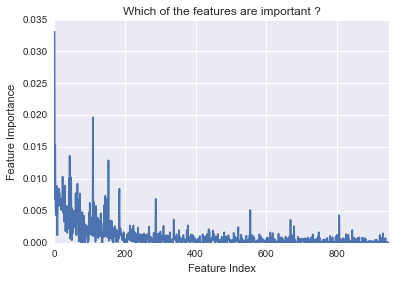

In [98]:
pd.Series(rf.feature_importances_).plot()
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Which of the features are important ?');

In [63]:
feature_indexes = np.argsort(rf.feature_importances_)[::-1]

In [71]:
important_features = train.columns[feature_indexes[:100]]

In [113]:
X = pd.DataFrame(X)
Xtest = pd.DataFrame(Xtest)

X.columns = train.columns.drop('Activity')
Xtest.columns = train.columns.drop('Activity')

## Split into training and test set

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=44)

In [115]:
rf.fit(X_train[feature_indexes], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
predsTrain = rf.predict_proba(X_train)[:, 1]
predsTest = rf.predict_proba(X_test)[:, 1]

In [117]:
print 'Log loss score on the training set %f ' %(log_loss(y_train, predsTrain))
print 'Log loss score on the test set %f ' %(log_loss(y_test, predsTest))

Log loss score on the training set 0.726625 
Log loss score on the test set 0.724199 


## How does log loss score change by adding more features ?

In [92]:
def get_log_loss_scores(est, feature_indexes, X_train, y_train, X_test, y_test):
    feature_range = np.arange(100, 1000, 50)
    features = X_train.columns[feature_indexes]
    errors = []
    
    for num_features in feature_range:
        imp_features = features[:num_features]
        est.fit(X_train[imp_features], y_train)
        
        predsTest = est.predict_proba(X_test[imp_features])[:, 1]
        errors.append(log_loss(y_test, predsTest))
    
    errors = np.array(errors)
    
    return feature_range, errors

In [93]:
feature_range, errors = get_log_loss_scores(rf, feature_indexes, X_train, \
                                           y_train, X_test, y_test)

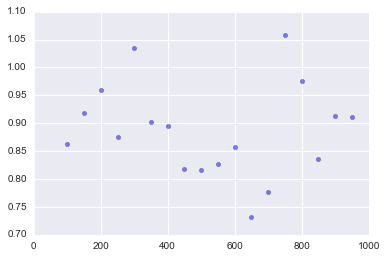

In [95]:
plt.scatter(feature_range, errors, alpha=0.5);

## How does log loss score change by increasing number of estimators ?

In [102]:
def get_errors_by_estimators(feature_indexes, X_train, X_test, y_train, y_test):
    features = feature_indexes[:650]
    
    n_estimator_range = [10, 25, 50, 75, 100, 150, 200]
    errors = []
    
    for n_estimator in n_estimator_range:
        rf = RandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        predsTest = rf.predict_proba(X_test)[:, 1]
        errors.append(log_loss(y_test, predsTest))
    
    errors = np.array(errors)
    return n_estimator_range, errors

In [103]:
n_estimator_range, errors = get_errors_by_estimators(feature_indexes, X_train, X_test, y_train, y_test)

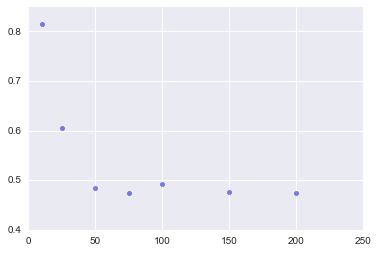

In [104]:
plt.scatter(n_estimator_range, errors, alpha=0.5);

In [106]:
n_estimator_range[np.argmin(errors)]

75

## Submission

In [119]:
rf = RandomForestClassifier(n_estimators=75, n_jobs=-1)
rf.fit(X[feature_indexes[:650]], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
predictions = rf.predict_proba(Xtest[feature_indexes[:650]])[:, 1]

In [127]:
submissions = pd.DataFrame({'MoleculeId': test.index.values + 1, 'PredictedProbability': predictions})
submissions.to_csv('./submissions/rf_benchmark.csv', index=False)

In [128]:
submissions.MoleculeId.max()

2501